# EtaPi PWA
based on demo_JPAC_fit.ipynb

In [1]:
import sys
sys.version

'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'

In [2]:
# Scientific stack
import pandas
import numpy as npy
import emcee
import PyPWA as pwa


# system
from importlib import reload
from copy import deepcopy
import os
import random
import time
import collections
import pickle
from multiprocessing import Pool
from multiprocessing.pool import ThreadPool

# plotting
from IPython.display import display
import matplotlib.pyplot as plt
import corner
import warnings
warnings.filterwarnings('ignore')

# amplitudes
import AmplitudeJPACfit
import AmplitudeJPACfitAngles


from sklearn.neighbors import KernelDensity

In [3]:
import matplotlib
SMALL_SIZE = 14
MEDIUM_SIZE = 20
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Create results directory

In [4]:
# try to stick to [epsilon][L][M]_[epsilon][L][M]_...
outputpath = "example"
try:
    os.makedirs(outputpath)
except OSError:
    if os.path.isdir(outputpath):
        print(f"Directory {outputpath} already exists.")
    else:
        print (f"Creation of the directory {outputpath} failed.")
else:
    print (f"Successfully created the directory {outputpath}.")

Directory example already exists.


# Read processed data
pre-processed by process_data.py

In [5]:
# data_full = pwa.read("./zPhase1_data_GJ/phase1_data_data.csv")
# mc_full = pwa.read("./zPhase1_data_GJ/phase1_flat_data.csv")

# data_full_weight = pwa.read("./zPhase1_data_GJ/phase1_data_weights.csv")
# mc_full_weight = pwa.read("./zPhase1_data_GJ/phase1_flat_weights.csv")

baseFolder="/d/grid17/ln16/myDSelector/amptools/pypwa/mcmc_pypwa/zMalte_kmatrix_hel/"
data_full = pwa.read(baseFolder+"malte_kmatrix_data.csv")
mc_full = pwa.read(baseFolder+"flat_2018_8_data_000.csv")

data_full_weight = pwa.read(baseFolder+"malte_kmatrix_weights.csv")
mc_full_weight = pwa.read(baseFolder+"flat_2018_8_weights_000.csv")


# # Subset the datasets to make things run faster
# npy.random.seed(1992)
# data_sample=npy.random.choice(len(data_full),25000)
# data_full=data_full[data_sample]
# data_full_weight=data_full_weight[data_sample]

# mc_sample=npy.random.choice(len(mc_full),75000)
# mc_full=mc_full[mc_sample]
# mc_full_weight=mc_full_weight[mc_sample]

In [6]:
data_weight=data_full_weight#[data_full["beamAngle"]==0]
data=data_full#[data_full["beamAngle"]==0]

mc_weight=mc_full_weight#[mc_full["beamAngle"]==0]
mc=mc_full#[mc_full["beamAngle"]==0]

integrated MC yield: 183282.6875
integrated data yield: 96841.21875


array([[<AxesSubplot:title={'center':'EventN'}>,
        <AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'phi'}>],
       [<AxesSubplot:title={'center':'tM'}>,
        <AxesSubplot:title={'center':'mass'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beamAngle'}>,
        <AxesSubplot:title={'center':'pol'}>, <AxesSubplot:>]],
      dtype=object)

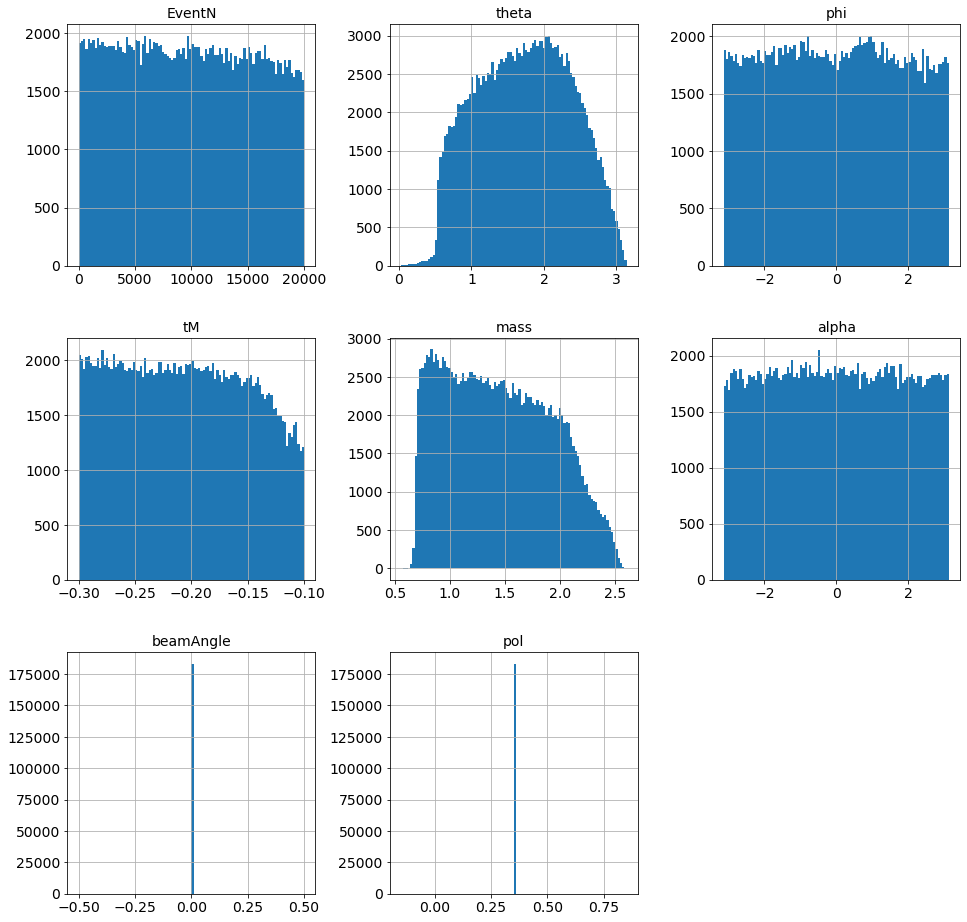

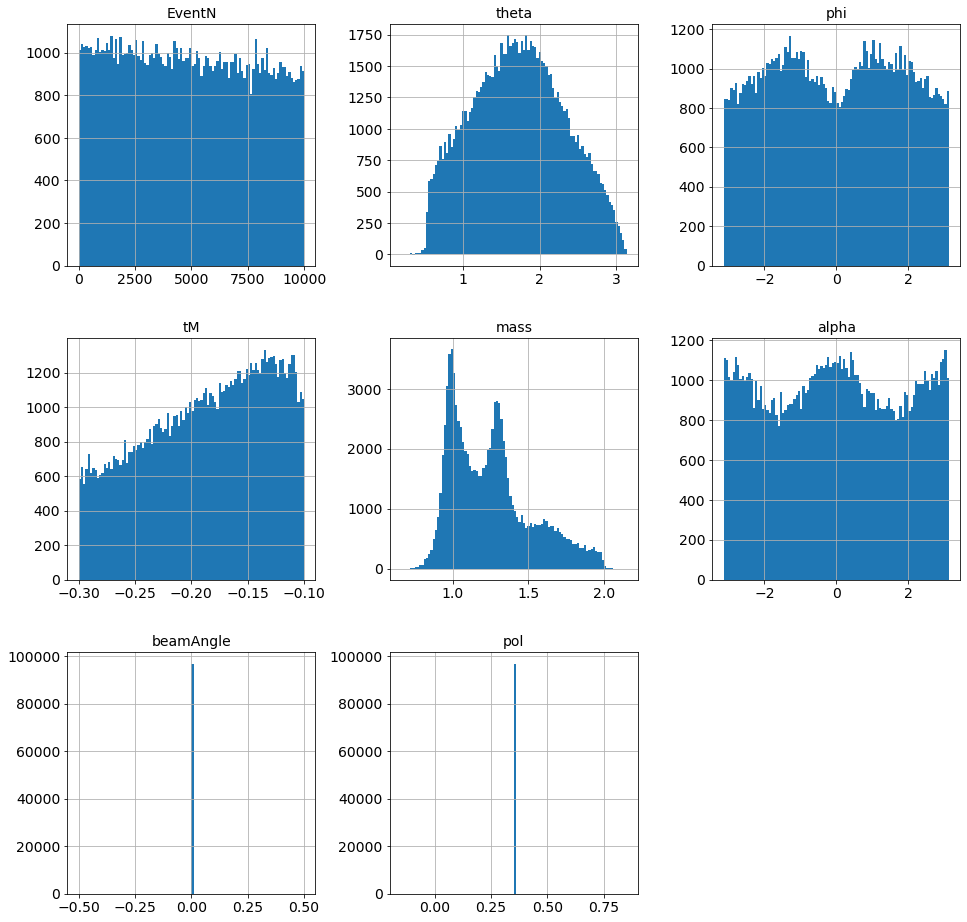

In [7]:
pd_mc=pandas.DataFrame(mc)
fig,ax=plt.subplots(1,1,figsize=(16,16))
pd_mc.hist(ax=ax,bins=100,weights=mc_weight["weightASBS"])

integral_mc=sum(mc_weight["weightASBS"])
integral_data=sum(data_weight["weightASBS"])
print(f"integrated MC yield: {integral_mc}")
print(f"integrated data yield: {integral_data}")

pd_data=pandas.DataFrame(data)
fig,ax=plt.subplots(1,1,figsize=(16,16))
pd_data.hist(ax=ax,bins=100,weights=data_weight["weightASBS"])

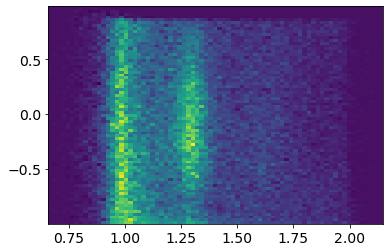

In [8]:
_=plt.hist2d(pd_data.mass,npy.cos(pd_data.theta),bins=(75,75),weights=data_weight["weightASBS"])

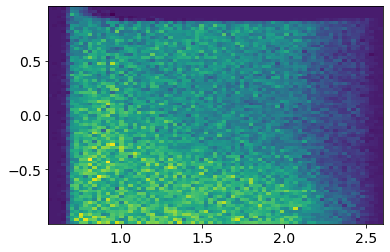

In [9]:
_=plt.hist2d(pd_mc.mass,npy.cos(pd_mc.theta),bins=(75,75),weights=mc_weight["weightASBS"])

# Define Waves for Fit (and input initial values of minuit and fitted parameters).

### Fit real and imaginary parts

In [10]:
def setupWave(waveset):
    Vs = {"errordef": 1}
    initial = []
    for waveConfig in waveset:
        wave, anchor = waveConfig
        for param_type in ["r", "i"]:
            initial.append(f"{param_type}.{wave}")
            if anchor and param_type=="i":
                Vs[f"{param_type}.{wave}"] = 0
                Vs[f"fix_{param_type}.{wave}"]=True
            else:
                Vs[f"{param_type}.{wave}"] = random.uniform(-200,200)
    #             Vs[f"limit_{param_type}.{wave}"] = [-500, 1500.]
    #             Vs[f"error_{param_type}.{wave}"] = .1
    return initial, Vs

In [11]:
waveset=[
    # S-waves
    ["1.0.0",True],
    ["-1.0.0",True],
    
    # D-waves
    ["1.2.0",False],
    ["1.2.1",False],
    ["1.2.2",False],
    ["-1.2.-1",False],
    ["-1.2.0",False],
    ["-1.2.1",False],
    
    # P-waves
    ["1.1.0",False],
    ["1.1.1",False],
    ["-1.1.0",False],
    ["-1.1.1",False]
]

initial,Vs = setupWave(waveset)
    
with open(f'{outputpath}/wave_set.csv', 'w') as file:
    for key in Vs.keys():
        file.write(f"{key},{Vs[key]}\n")

### Define amplitude and phase

In [12]:
# Vs = {"errordef": 1}

# initial = []
# for param_type in ["a", "p"]: #try to fit magnitude and angle
#     initial.append(f"{param_type}.1.0.0")
#     initial.append(f"{param_type}.1.1.0")
#     initial.append(f"{param_type}.1.1.1")
#     initial.append(f"{param_type}.1.2.0")
#     initial.append(f"{param_type}.1.2.1")
#     initial.append(f"{param_type}.1.2.2")
# #     initial.append(f"{param_type}.1.2.-1")
# #     initial.append(f"{param_type}.1.2.-2")
    
# Vs[f"a.1.0.0"] = 10
# Vs[f"limit_a.1.0.0"] = [0, 1500.]
# Vs[f"error_a.1.0.0"] = .1

# Vs[f"a.1.1.0"] = 10
# Vs[f"limit_a.1.1.0"] = [0, 1500.]
# Vs[f"error_a.1.1.0"] = .1

# Vs[f"a.1.1.1"] = 10
# Vs[f"limit_a.1.1.1"] = [0, 1500.]
# Vs[f"error_a.1.1.1"] = .1

# Vs[f"a.1.2.0"] = 10
# Vs[f"limit_a.1.2.0"] = [0, 1500.]
# Vs[f"error_a.1.2.0"] = .1

# Vs[f"a.1.2.1"] = 10
# Vs[f"limit_a.1.2.1"] = [0, 1500.]
# Vs[f"error_a.1.2.1"] = .1

# Vs[f"a.1.2.2"] = 10
# Vs[f"limit_a.1.2.2"] = [0, 1500.]
# Vs[f"error_a.1.2.2"] = .1 

# # Vs[f"a.1.2.-1"] = 10
# # Vs[f"limit_a.1.2.-1"] = [0, 1500.]
# # Vs[f"error_a.1.2.-1"] = .1

# # Vs[f"a.1.2.-2"] = 10
# # Vs[f"limit_a.1.2.-2"] = [0, 1500.]
# # Vs[f"error_a.1.2.-2"] = .1

# Vs[f"p.1.0.0"] = 0
# Vs[f"limit_p.1.0.0"] = [0, 2*npy.pi]
# Vs[f"error_p.1.0.0"] = .01
# Vs[f"fix_p.1.0.0"] = True

# Vs[f"p.1.1.0"] = 0
# Vs[f"limit_p.1.1.0"] = [0, 2*npy.pi]
# Vs[f"error_p.1.1.0"] = .01

# Vs[f"p.1.1.1"] = 0
# Vs[f"limit_p.1.1.1"] = [0, 2*npy.pi]
# Vs[f"error_p.1.1.1"] = .01

# Vs[f"p.1.2.0"] = 0
# Vs[f"limit_p.1.2.0"] = [0, 2*npy.pi]
# Vs[f"error_p.1.2.0"] = .01

# Vs[f"p.1.2.1"] = 0
# Vs[f"limit_p.1.2.1"] = [0, 2*npy.pi]
# Vs[f"error_p.1.2.1"] = .01

# Vs[f"p.1.2.2"] = 0
# Vs[f"limit_p.1.2.2"] = [0, 2*npy.pi]
# Vs[f"error_p.1.2.2"] = .01 

# # Vs[f"p.1.2.-1"] = 0
# # Vs[f"limit_p.1.2.-1"] = [0, 2*npy.pi]
# # Vs[f"error_p.1.2.-1"] = .01

# # Vs[f"p.1.2.-2"] = 0
# # Vs[f"limit_p.1.2.-2"] = [0, 2*npy.pi]
# # Vs[f"error_p.1.2.-2"] = .01
    

# print(Vs)

# with open(f'{outputpath}/wave_set.csv', 'w') as file:
#     for key in Vs.keys():
#         file.write(f"{key},{Vs[key]}\n")

In [13]:
amplitude = AmplitudeJPACfit.FitAmplitude(initial)
# import AmplitudeJPACfitAngles
# amplitude = AmplitudeJPACfitAngles.FitAmplitude(initial)

# Binning of the data/monte-carlo and __define amplitude (function) to fit__
> Here the user defines number of bins, variable to be binned and range

In [14]:
#Define number of bins 
nbins = 30 #45
mmin=0.8 #0.7
mmax=2.0 #2.5
binsda = pwa.bin_by_range(data, "mass", nbins, mmin, mmax)
binsmc = pwa.bin_by_range(mc, "mass", nbins, mmin, mmax)
binsda_w = pwa.bin_by_range(data_weight, "mass", nbins, mmin, mmax)
binsmc_w = pwa.bin_by_range(mc_weight, "mass", nbins, mmin, mmax)

In [15]:
for i in range(len(binsda)):
    print("bin{0} (data, mc): ({1},{2})".format(i,len(binsda[i]),len(binsmc[i])))

bin0 (data, mc): (1814,19804)
bin1 (data, mc): (4714,20668)
bin2 (data, mc): (11479,21287)
bin3 (data, mc): (24005,21357)
bin4 (data, mc): (32785,20327)
bin5 (data, mc): (28994,18610)
bin6 (data, mc): (22172,17692)
bin7 (data, mc): (17514,16519)
bin8 (data, mc): (15158,16329)
bin9 (data, mc): (15107,16262)
bin10 (data, mc): (17343,15799)
bin11 (data, mc): (20753,15869)
bin12 (data, mc): (21804,15517)
bin13 (data, mc): (17348,15430)
bin14 (data, mc): (11860,15217)
bin15 (data, mc): (8371,15056)
bin16 (data, mc): (7084,15150)
bin17 (data, mc): (6555,14847)
bin18 (data, mc): (6429,14710)
bin19 (data, mc): (6607,14945)
bin20 (data, mc): (6721,14455)
bin21 (data, mc): (6202,14166)
bin22 (data, mc): (5493,14137)
bin23 (data, mc): (4628,13870)
bin24 (data, mc): (3919,13589)
bin25 (data, mc): (3432,13519)
bin26 (data, mc): (3109,13467)
bin27 (data, mc): (2856,13199)
bin28 (data, mc): (2415,12680)
bin29 (data, mc): (1572,12414)


Plot events per bin for visualisation and to make sure there are enough events per bin

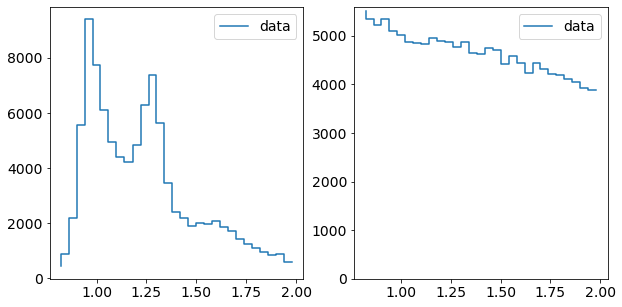

In [16]:
fig,ax=plt.subplots(1,2,figsize=(10,5))

### DATA
counts=[]
centers=[]
for ibin,bin in enumerate(binsda):
    counts.append(npy.sum(binsda_w[ibin]["weightASBS"]))
    centers.append(npy.mean(bin["mass"]))

# Add yerr to argment list when we have errors
ax[0].step(centers,counts,label='data')
ax[0].legend(loc='upper right')

### FLAT
counts=[]
centers=[]
for ibin,bin in enumerate(binsmc):
    counts.append(npy.sum(binsmc_w[ibin]["weightASBS"]))
    centers.append(npy.mean(bin["mass"]))

# Add yerr to argment list when we have errors
ax[1].step(centers,counts,label='data')
ax[1].set_ylim(bottom=0)
ax[1].legend(loc='upper right')

In [17]:
intensities = []
for the_bin in binsda:
    amplitude.setup(the_bin)

# Fitting with Minuit and Extended LogLikelihood
> Look at other possibilities through pypwa (use the ?pwa command\
> or see https://pypwa.jlab.org or https://github.com/JeffersonLab/PyPWA)

In [ ]:
def spawnFit(index):
    #############
    # Arguments to PyPWA's minuit
    # https://github.com/JeffersonLab/PyPWA/blob/342026d5ea9ac37c437081c495142269cbcbe112/PyPWA/libs/fit/minuit.py
    #############
    # parameters : List[str]
    #     The names of the parameters for iminuit to use
    # settings : Dict[str, Any]
    #     The settings to be passed to iminuit. Look into the documentation
    #     for iminuit for specifics
    # likelihood : Likelihood object from likelihoods or single function
    # set_up : float
    #     Set to 1 for log-likelihoods, or .5 for Chi-Squared
    # strategy : int
    #     Fitting strategy. Defaults to 1. 0 is slowest, 2 is fastest/
    # num_of_calls : int
    #     A suggested max number of calls to minuit. This may or may not
    #     be respected.

    # MINUIT itself contains arguments. i.e.
    # to get the functions minimum we can use fval on the optimizer:
    # https://iminuit.readthedocs.io/en/stable/reference.html
    
    ##############
    # Likelihood arguments
    # https://github.com/JeffersonLab/PyPWA/blob/342026d5ea9ac37c437081c495142269cbcbe112/PyPWA/libs/fit/likelihoods.py
    ##############
    
    print(f" - process{index} started")
    start=time.time() 
    results[index]=[]
    for ifit in range(nfits):
        initial,Vs = setupWave(waveset)
        with pwa.LogLikelihood(
            amplitude, binsda[index], binsmc[index], quality_factor=binsda_w[index]["weightASBS"],
            quality_factor_mc=binsmc_w[index]["weightASBS"],
            #generated_length=len(binsmc_w[index]["weightASBS"]),
            num_of_processes=1) as Likelihood:
#             results[index].append(pwa.minuit(initial, Vs, Likelihood, 1, 1, 5000))
            optim=pwa.minuit(initial, Vs, Likelihood, 1, 1, 5000)
            stats=[
                [optim.fmin.is_valid,optim.fmin.fval],
                optim.np_values(),
                optim.np_errors(),
                optim.covariance
            ]
            results[index].append(stats)
    end=time.time()
    print(f"Fit #{index} done in {end-start}s")

print("Starting pool of workers...")
globalStart = time.time()
results = {}
nfits=25 # fits per bin
nthreads=15
assert nthreads <= nbins

with ThreadPool(nthreads) as p:
    p.map(spawnFit,range(len(binsda)))
globalEnd = time.time()

# sort the dictionary of minimizers by the keys (bin number)
results=list(collections.OrderedDict(sorted(results.items())).values())

print("Elapsed time: {}".format(globalEnd-globalStart))

In [ ]:
resultsDict={}
for ibin,result in enumerate(results):
    resultsDict[f"bin{ibin}"]={}
    for ifit,result in enumerate(results[ibin]):
        resultsDict[f"bin{ibin}"][f"fit{ifit}"] = results[ibin][ifit]
#         [
#             [result.fmin.is_valid,result.fmin.fval],
#             results[ibin][ifit].np_values(),
#             results[ibin][ifit].np_errors()
#         ]
#print(f"Total bins: {countbins}")

In [ ]:
print(f"number of bins: {len(resultsDict.keys())}")
for bin_key in resultsDict.keys():
    print(f"number of fits in {bin_key}: {len(resultsDict[bin_key])}")

In [ ]:
fval_idxs=[]
all_invalid_fits_idxs=[]
for ibin,bin_key in enumerate(resultsDict.keys()):
    print(bin_key)
    fval_min=npy.inf
    fval_idx=0
    n_valid=0
    for ifit,fit_key in enumerate(resultsDict[bin_key].keys()):
        fval=resultsDict[bin_key][fit_key][0][1]
        status=resultsDict[bin_key][fit_key][0][0]
        status="valid" if status else "invalid"
        print(f"  ({ifit})({status})fval: {fval}")
        if fval < fval_min:
            fval_min=fval
            fval_idx=ifit
        if status=="valid":
            n_valid+=1
    if n_valid==0:
        all_invalid_fits_idxs.append(ibin)
    print(f"  --- Best fval={fval_min} at idx={fval_idx}")
    print(f"  --- # valid status={n_valid}")
    fval_idxs.append(fval_idx)

In [ ]:
resultsBest=[]
resultsBestErrs=[]
resultsBest_optimizer=[]
for binNum,bin_key in enumerate(resultsDict.keys()):
    fval_idx=fval_idxs[binNum]
    resultsBest.append(resultsDict[bin_key][f"fit{fval_idx}"][1])
    resultsBestErrs.append(resultsDict[bin_key][f"fit{fval_idx}"][2])
    resultsBest_optimizer.append(results[binNum][fval_idx])
resultsBest=npy.array(resultsBest)
resultsBestErrs=npy.array(resultsBestErrs)

In [ ]:
# Having trouble pickling the fit results. Will just save the important values and reconstruct the necessary outputs...
resultsData={ "best":resultsBest, "best_err": resultsBestErrs, "data":resultsDict , "parameters":initial }

## Writing minuit fit results

In [ ]:
pickle.dump(resultsData,open("minuit_results_test_3rd.pkl","wb"))

In [ ]:
final_values = pandas.DataFrame(resultsData["best"], columns=resultsData["parameters"])
final_values.to_csv(f"{outputpath}/minuit.csv", index=False)

final_errs = pandas.DataFrame(resultsData["best_err"], columns=resultsData["parameters"])
final_errs.to_csv(f"{outputpath}/minuit_err.csv", index=False)

## Reading minuit fit results

In [18]:
resultsData=pickle.load(open("minuit_results_test_3rd.pkl","rb"))
#resultsData=pickle.load(open("./zPhase1_data_fit_results_GJ/minuit_results_20iters.pkl","rb"))

# Plotting results of the fitting

*Checking the waves used (and filling waves variable for later use)*

In [19]:
waves = amplitude.make_elm(resultsData["parameters"])

*Filling strings with wave names (for plotting)*

In [20]:
wave = npy.empty(len(waves),dtype="int")
string = npy.empty(len(waves),dtype="U5")
for index, w in waves.iterrows():
    #print(w["l"])
    string[index]= "{}{}{}".format(w["e"],w["l"],w["m"])
    wave[index]=w.name

*Getting the bin mass values and number of events in datasample for those bins*

In [21]:
bmass=[]
mcounts=[]
for index, bin in enumerate(binsda):
    if len(bin)==0:
        bmass.append(0.)
        mcounts.append(0.)
    else:
        bmass.append(npy.average(bin["mass"]))
        mcounts.append(npy.sum(binsda_w[index]["weightASBS"]))

# Calculating the expected number of events in a mass bin

In [22]:
total_nExp = npy.empty(len(binsmc))
for index, the_bin, result in zip(range(len(binsmc)), binsmc, resultsData["best"]):
    amp=amplitude
    amp.setup(the_bin)
    resultMap={resultsData["parameters"][i]:result[i] for i in range(resultsData["best"].shape[1])}
    total_nExp[index] = npy.average(binsmc_w[index]["weightASBS"]*amp.calculate(resultMap))

*Plot expected number of events vs mass and data vs mass (both should agree if fitting worked)*

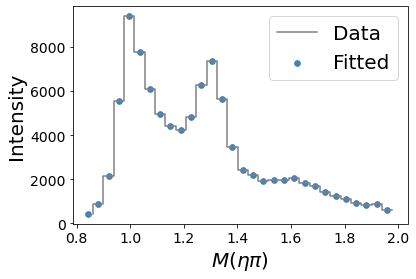

In [23]:
mni = npy.empty(len(total_nExp), dtype=[("mass", float), ("int", float)])
mda = npy.empty(len(mcounts), dtype=[("mass", float), ("intd", float)])
mni["mass"] = bmass
mni["int"] = total_nExp
mni = pandas.DataFrame(mni)
counts, bin_edges = npy.histogram(mni["mass"], nbins, weights=mni["int"])
mda["mass"] = bmass
mda["intd"] = mcounts
mda = pandas.DataFrame(mda)
dcounts, bin_edges = npy.histogram(mda["mass"], nbins, weights=mda["intd"])
#dcounts, bin_edges = npy.histogram(bmass, nbins, weights=total_nExp)
centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Add yerr to argment list when we have errors
yerr = npy.empty(nbins)
yerr = npy.sqrt(counts)
myerr = npy.empty(nbins)
myerr = npy.sqrt(dcounts)

#plt.errorbar(centers,counts, yerr, fmt="s",linestyle="dashed",markersize='10',label="nExp")
width=(centers[1]-centers[0])/2
plt.step(centers+width,mcounts,label="Data",linestyle='-',c='gray')
plt.scatter(centers,total_nExp,label="Fitted",linestyle='-',s=32,color='steelblue',alpha=1)
plt.legend(loc='upper right',prop={"size":20})
plt.xlabel(r"$M(\eta\pi)$",size=20)
plt.ylabel("Intensity",size=20)
plt.show()

Calculate initial intensities (in case we need to check them)

In [24]:
intensities = []
for the_bin in binsda:
    amp.setup(the_bin)
    intensities.append(amp.calculate(Vs))
intesities=pandas.DataFrame(intensities)

# Calculate the expected number of events for each wave (vs mass)

In [25]:
####################
# Calculate the wave content
####################  

total_nExp = npy.empty(len(binsmc))
for index, the_bin, result in zip(range(len(binsmc)), binsmc, resultsData["best"]):
    amp=amplitude
    amp.setup(the_bin)
    resultMap={resultsData["parameters"][i]:result[i] for i in range(resultsData["best"].shape[1])}
    total_nExp[index] = npy.average(binsmc_w[index]["weightASBS"]*amp.calculate(resultMap))


wave_nExp = npy.empty([len(waves),len(binsmc)],npy.longdouble)
for index, the_bin, result in zip(range(len(binsmc)), binsmc, resultsData["best"]):
    amp.setup(the_bin)
    resultMap={resultsData["parameters"][i]:result[i] for i in range(resultsData["best"].shape[1])}
    for i in range(len(waves)):
        wave_nExp[i][index] = npy.average(binsmc_w[index]["weightASBS"]*amp.calculate_wave(resultMap,i))

# Expected number of events vs mass for each wave in a same plot

In [26]:
# look for the unique LM waves. We will plot each LM wave on a different axis
#   with different colors for the + and - reflectivity waves
lms=[]
for i,w in waves.iterrows():
    lm=f"{w['l']}_{w['m']}"
    lms.append(lm)
lms=npy.unique(npy.array(lms))
lms=[lm.split("_") for lm in lms]
lms0=[lm for lm in lms if lm[0]=='0']
lms1=[lm for lm in lms if lm[0]=='1']
lms2=[lm for lm in lms if lm[0]=='2']
lms=lms0+lms2+lms1
lms=npy.array(lms)

# Need to track which array element holds which wave
mapWaves={wave:i for i,wave in enumerate(string)}

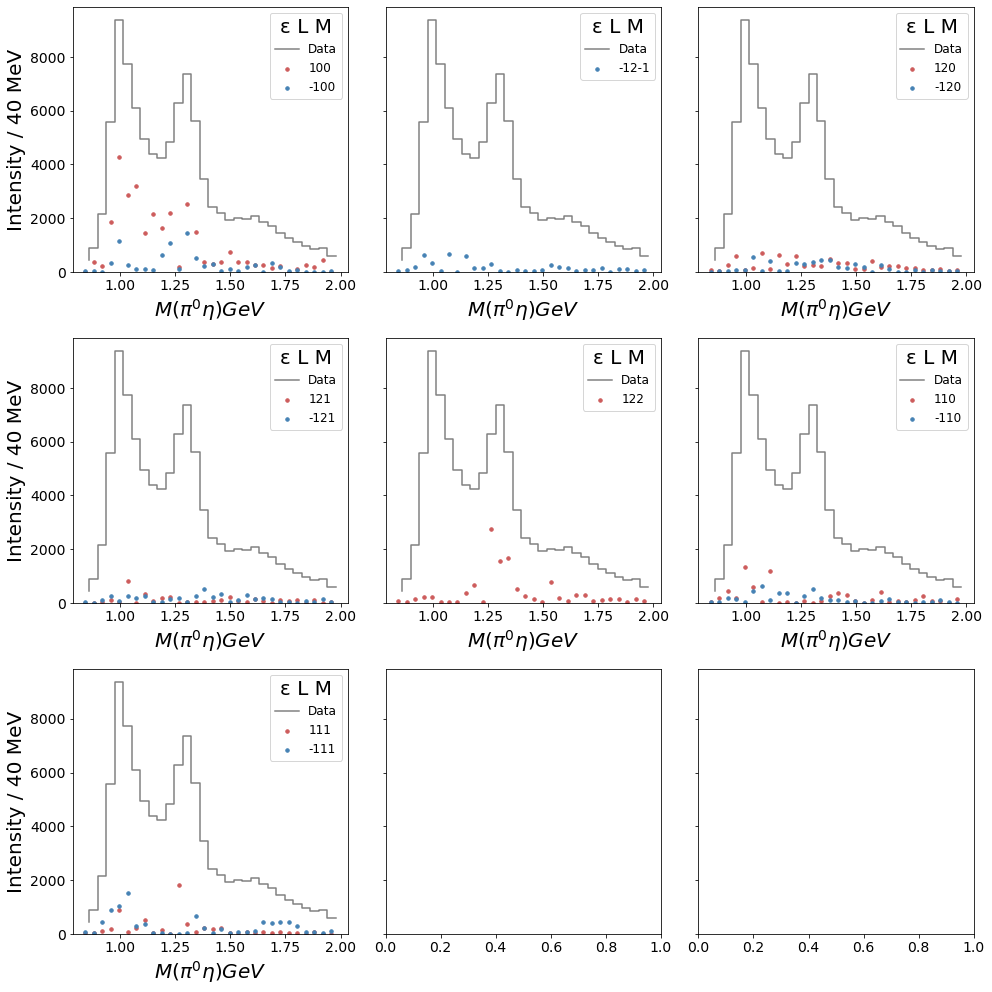

In [27]:
######################
# Make the final plot
######################

fig,ax=plt.subplots(3,3,figsize=(14,14),sharey=True)
ax=ax.flatten()

for iax,lm in enumerate(lms):
    ax[iax].step(centers+width,mcounts,label="Data",linestyle='-',c='gray')
    for ref in ["1","-1"]:
        if ref+lm[0]+lm[1] in mapWaves:
            i = mapWaves[ref+lm[0]+lm[1]]
            color = "indianred" if ref=="1" else "steelblue"
            ax[iax].scatter(centers,wave_nExp[i],label=string[i],c=color,s=12)
    legend=ax[iax].legend(loc='upper right', title="ε L M",prop={"size":12})
    legend.get_title().set_fontsize('20')
    ax[iax].set_xlabel(r"$M(\pi^0\eta) GeV$",size=20)
    ylims=ax[iax].set_ylim(bottom=0)
    
for iax in [0,3,6]:
    ax[iax].set_ylabel("Intensity / 40 MeV",size=20)

plt.tight_layout()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


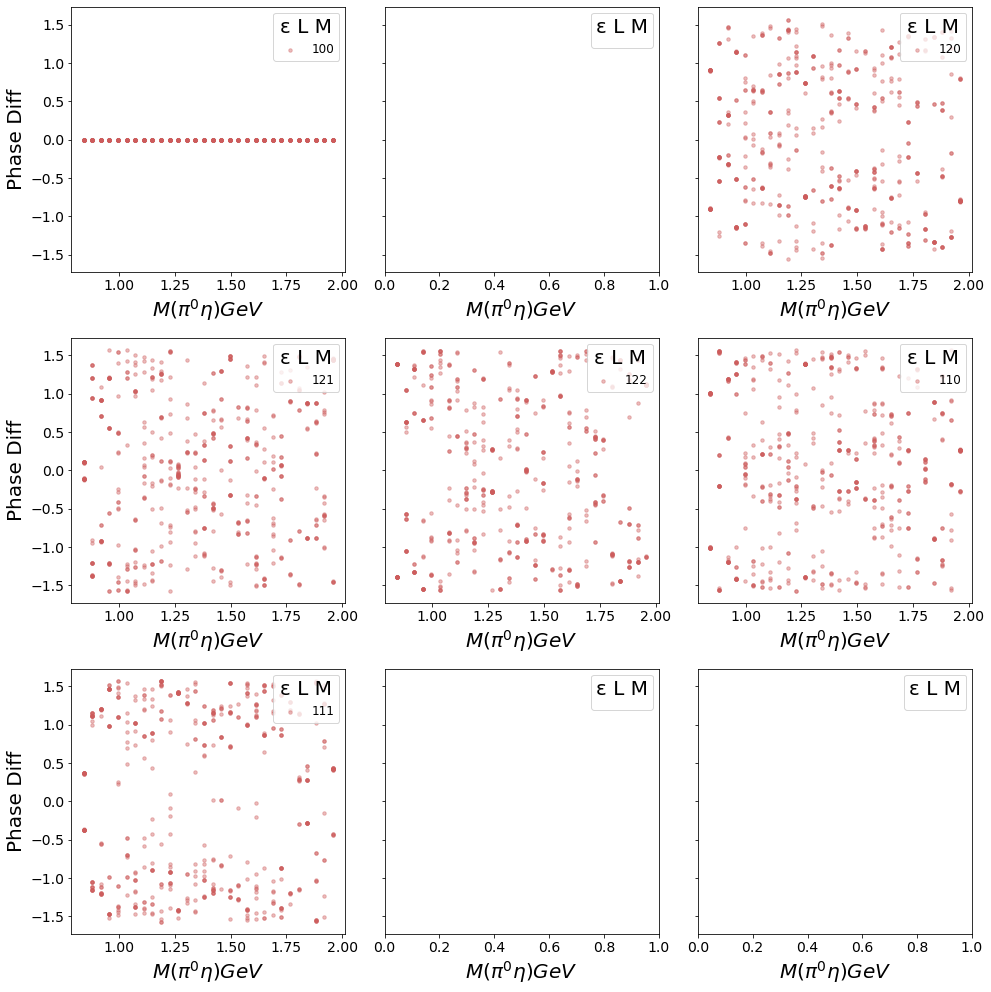

In [28]:
######################
# Make the final plot
######################

# Set up the wave labels 
waves=amplitude.make_elm(resultMap)

wave = npy.empty(len(waves),dtype="int")
string = npy.empty(len(waves),dtype="U5")
for index, w in waves.iterrows():
    #print(w["l"])
    string[index]= "{}{}{}".format(w["e"],w["l"],w["m"])
    wave[index]=w.name


fig,axes=plt.subplots(3,3,figsize=(14,14),sharey=True)
axes=axes.flatten()

for index, the_bin, bin_key in zip(range(len(binsmc)), binsmc, list(resultsData["data"].keys())):
#     if index>0:
#         continue
    amp.setup(the_bin)
    fits = [ resultsData["data"][bin_key][fit_key][1] for fit_key in resultsData["data"][bin_key].keys() 
           if resultsData["data"][bin_key][fit_key][0][0] ]

    for iax,lm in enumerate(lms):
        for ref in ["1"]:
            if ref+lm[0]+lm[1] in mapWaves:
                i = mapWaves[ref+lm[0]+lm[1]]
                color = "indianred" if ref=="1" else "steelblue"
            else:
                continue
            
            wave_nExp = npy.empty(len(fits),npy.longdouble)
            for ifit,fit in enumerate(fits):
                resultMap=dict(zip(resultsData["parameters"],fit))
                
                #print(f"calculating phase diff between: {string[wave[0]]},{string[wave[i]]}")
#                 wave_nExp[ifit] = npy.abs(npy.average(binsmc_w[index]["weightASBS"]*amp.Phasediff(resultMap,wave[0],wave[i])))
                wave_nExp[ifit] = amp.Phasediff(resultMap,wave[0],wave[i])
                
            if index==0:
                axes[iax].scatter([centers[index]]*len(fits),wave_nExp,label=string[i],c=color,s=12,alpha=0.4)
            else:
                axes[iax].scatter([centers[index]]*len(fits),wave_nExp,c=color,s=12,alpha=0.4)
                
for ax in axes:
    legend=ax.legend(loc='upper right', title="ε L M",prop={"size":12})
    legend.get_title().set_fontsize('20')
    ax.set_xlabel(r"$M(\pi^0\eta) GeV$",size=20)
    #ylims=ax.set_ylim(bottom=0)
    
for iax in [0,3,6]:
    axes[iax].set_ylabel("Phase Diff",size=20)

plt.tight_layout()

# Read fitted amplitudes from disk

In [29]:
def convertToAP(samples):
    '''
    Convert samples from real/imaginary to amplitude/phase
    '''
    apsamples=npy.zeros(samples.shape)

    waves=[amp[2:] for amp in initial if amp[0]=="r"]

    for iw,wave in enumerate(waves):
        apsamples[...,2*iw]=npy.sqrt(samples[...,2*iw]**2+samples[...,2*iw+1]**2)
        apsamples[...,2*iw+1]=npy.arctan(samples[...,2*iw+1],samples[...,2*iw])
#         apsamples[...,2*iw+1]=npy.arctan2(samples[...,2*iw+1],samples[...,2*iw])
#         apsamples[...,2*iw+1][npy.abs(apsamples[...,2*iw+1]-3.14159) < 0.00001] = 0.0
    return apsamples


def convertToAP2(samples):
    '''
    Convert samples from real/imaginary to amplitude/phase
    '''
    apsamples=npy.zeros(samples.shape)

    waves=[amp[2:] for amp in initial if amp[0]=="r"]

    for iw,wave in enumerate(waves):
        apsamples[...,2*iw]=npy.sqrt(samples[...,2*iw]**2+samples[...,2*iw+1]**2)
        apsamples[...,2*iw+1]=npy.arctan(samples[...,2*iw+1],samples[...,2*iw])
#         apsamples[...,2*iw+1]=npy.arctan2(samples[...,2*iw+1],samples[...,2*iw])
#         apsamples[...,2*iw+1][npy.abs(apsamples[...,2*iw+1]-3.14159) < 0.00001] = 0.0
    return apsamples

In [30]:
#minuitresults = pandas.read_csv(f"{outputpath}/minuit.csv")
minuitresults = pandas.DataFrame(resultsData["best"],columns=resultsData["parameters"])

## Setup fit config for amp / phase

######################
# Define ap waveset
######################
apinitial = []
for val in initial:
    if val.startswith('r'):
        apinitial.append(val.replace('r.','a.'))
    else:
        apinitial.append(val.replace('i.','p.'))
    
######################
# Convert from re/im to amp/phase
######################
amplitudeAngles = AmplitudeJPACfitAngles.FitAmplitude(apinitial)
waves=[amp[2:] for amp in initial if amp[0]=="a" or amp[0]=="i"]

apminuitresults=minuitresults.copy()
apminuitresults=pandas.DataFrame(convertToAP(apminuitresults.values),columns=apinitial)

In [31]:
index=0
_label="ri" #ap
_amplitude=amplitude #amplitudeAngles
_results=minuitresults # apminuitresults
_initial=initial #apinitial
startvals = _results.loc[index].copy()
if _label == "ri":
    for p in range(len(startvals)):
        if startvals[p]!=0:
            startvals[p] = startvals[p]*(1+npy.random.rand())

# Run MCMC

In [94]:
################################
# Configuration
################################
numwalker=100
numsteps=100000 # the autocorrelation time seems to be around 150 for our chains
ncpu=2 # best is ~ 2
nthreads=1

_label="ri" #ap
_amplitude=amplitude #amplitudeAngles
_results=minuitresults # apminuitresults
_initial=initial #apinitial
################################
################################

In [ ]:
# THINNING: (thin)ning is rarely recommended these days. There are correlations betweeen nearby samples inherent in the sample procedure.
# We can reduce the correlation by thinning the chain, basically grabbing every other Nth sample. This does reduce the chains length and therefore
# the variance of the approximation BUT does gives us better iid samples if that were every needed
# https://stats.stackexchange.com/questions/442714/why-does-thinning-work-in-bayesian-inference


def spawnMCMC(index):
#     with pwa.LogLikelihood(
#         amplitude, dbin, binsma[index], generated_length=len(binsma[index]), num_of_processes=ncpu, is_minimizer=False) as Likelihood:
    with pwa.LogLikelihood(
        _amplitude, binsda[index], binsmc[index], quality_factor=binsda_w[index]["weightASBS"],
        quality_factor_mc=binsmc_w[index]["weightASBS"],
        num_of_processes=ncpu, is_minimizer=False) as Likelihood:
        print(f"Find random start parameters for fit #{index}...")
        startpars = npy.zeros((numwalker,len(_initial)))
        for i in range(numwalker):
            a=0
            while True:
                a+=1
                
                #add some randomization here for moves to work better
                startvals = _results.loc[index].copy()
                if _label == "ri":
                    for p in range(len(startvals)):
                        if startvals[p]!=0:
                            startvals[p] = startvals[p]*(1+npy.random.uniform(-0.1,0.1))#-0.5,0.5))
                else:
                    for iw in range(0,len(waves)):
                        startvals[2*iw] = startvals[2*iw]*(1+npy.random.uniform(-0.1,0.1))#-0.5,0.5))
                        #initialise the phases with an overall offset to go round on the circle. 
                        #We will get the remainder first and then scale
                        startvals[2*iw+1] = (startvals[2*iw+1] % (2*npy.pi))*(1+npy.random.uniform(-0.1,0.1))#-0.5,0.5))
                    startvals[1]=0 #fix phase for s wave
                    startvals[3]=0 #fix phase for s wave

                nll = Likelihood(startvals.to_dict())
                if not npy.any(npy.isnan(nll)):
                    break
                    
                    
            # print(f"After {a} steps found nll={nll}.") #debugging
            startpars[i] = list(startvals)

        cov =  1 #npy.array([0.002,0.002,0.002,0.005,0.005,0.005,0.005,0.005,0.005,1E5])
        if _label == "ri":  
            parlimits = [(-1000,1000),(0,0),(-1000,1000),(0,0)] # set the s-waves to be real
            for i in range(4,len(_initial)):
                parlimits.append((-1000,1000))
        else:
            parlimits=[[] for i in range(2*len(waves))]
            for iw in range(0,len(waves)):
                parlimits[2*iw]=(0,1500) 
                if iw<2: # fix the s-waves
                    parlimits[2*iw+1]=(0,0)
                else:
                    parlimits[2*iw+1]=(0,2*npy.pi) 

        print(f"Start chain for bin {index} ...")
        # https://emcee.readthedocs.io/en/stable/user/moves/#moves-user
        # Sample from a set of moves. Moves are broken up into two paths {RedBlueMove, MHMove} which are parallel and non-parallel I think. These are two
        #         base abstract classes that other moves inherit from. GaussianMove is a MHMove with a Gaussian proposal function
        # StretchMove - Moving the walker based on a complementary walker
        # DE = Differential evolution, Multiple chains are run in parallel. The current move depends on two other chains. 
        #           Successful sampling requires at least 2*d chains where d is the dimensionality of the posterior
        # DESnooker applies a snooker move which allows for shorter chains. The move respects past states of other chains and thus allows for parallelization
        optimizer = pwa.mcmc(
                        _initial,
                        likelihood=Likelihood,
                        nsteps=numsteps,
                        startpars=startpars,
                        parlimits=parlimits,
                        nwalker=numwalker,
                        progress=False,
                        #emceemoves=[(emcee.moves.GaussianMove(cov=[10]*len(initial)),1.0)])
                        emceemoves=[(emcee.moves.StretchMove(a=2))]#, (emcee.moves.DEMove(), 0.0), (emcee.moves.DESnookerMove(), 0.0)])
                        #emceemoves=[(emcee.moves.StretchMove(), 0.9*0.1), (emcee.moves.DEMove(), 0.9*0.9), (emcee.moves.DESnookerMove(), 0.1)])
#                              emceemoves=emcee.moves.StretchMove())
#                              emceemoves=emcee.moves.GaussianMove(cov,'vector'))
        )


    _resultsMCMC[index]=optimizer
    
    acceptanceFraction=npy.mean(optimizer.acceptance_fraction)
    print("Mean acceptance fraction: {0:.3f}".format(npy.mean(optimizer.acceptance_fraction)))
    acceptanceFractions[index]=acceptanceFraction
    try:
        autocorrelationTime=npy.mean(optimizer.get_autocorr_time()) # will raise an error if autocorrelation too big, can quite=True it
        print("Mean autocorrelation time: {0:.3f} steps".format(autocorrelationTime))
        autocorrelationTimes[index]=autocorrelationTime
    except:
        print("Couldn't get autocorrelation time.")
        autocorrelationTimes[index] = -1
    
#     break #only one bin


print("Starting pool of workers for mcmc...")
globalStart = time.time()
_resultsMCMC = {}
acceptanceFractions = {}
autocorrelationTimes = {}

with ThreadPool(nthreads) as p:
    p.map(spawnMCMC,range(1))#range(len(binsda)))
globalEnd = time.time()

# sort the dictionary of minimizers by the keys (bin number)
_resultsMCMC=list(collections.OrderedDict(sorted(_resultsMCMC.items())).values())
acceptanceFractions=list(collections.OrderedDict(sorted(acceptanceFractions.items())).values())
autocorrelationTimes=list(collections.OrderedDict(sorted(autocorrelationTimes.items())).values())

print("Elapsed time: {}".format(globalEnd-globalStart))


Starting pool of workers for mcmc...
Find random start parameters for fit #0...
Start chain for bin 0 ...


In [101]:
results_pkl = {}
results_pkl["chain"] = [result.get_chain(discard=0) for result in _resultsMCMC]
#results_pkl["autocorr"] = [result.get_autocorr_time() for result in _resultsMCMC]
results_pkl["acceptance_fraction"] = [result.acceptance_fraction for result in _resultsMCMC]

pickle.dump(results_pkl, open("resultsMCMC_test.pkl","wb"))

# for i in range(len(binsda)):
#     samples = resultsMCMC[i].get_chain(discard=0)
#     pwa.write(f"{outputpath}/mcmc_mix_{numwalker}_{numsteps}_bin{i}.npy",samples)

# Read MCMC results

In [102]:
# nbins=45
# samplesList=[]
# for i in range(nbins):
#     samples=npy.load(f"{outputpath}/mcmc_mix_{numwalker}_{numsteps}_bin{i}.npy")
#     samplesList.append(samples)

In [103]:
# resultsMCMC = pickle.load(open("resultsMCMC.pkl","rb"))
# resultsMCMC = pickle.load(open("./zPhase1_data_fit_results_GJ/resultsMCMC_15ksteps_100walkers_10percRnd.pkl","rb"))

resultsMCMC = pickle.load(open("resultsMCMC_test.pkl","rb"))

samplesList=resultsMCMC["chain"]

In [126]:
samplesList[0].reshape(100000*100,24)

array([[-15.81794855,   0.        , -28.36220273, ..., -24.78928311,
         46.68660207, -11.97959039],
       [-15.35015525,   0.        , -32.71077528, ..., -21.86641711,
         44.56173953, -11.04569122],
       [-17.12587903,   0.        , -31.6268384 , ..., -22.5296982 ,
         42.90443006, -11.31698616],
       ...,
       [ 26.56935624,   0.        , -26.631912  , ...,  16.7690714 ,
         55.08235214, -24.2052007 ],
       [ 18.17595679,   0.        , -25.59705033, ..., -11.83256364,
         41.05691358,  37.15397027],
       [-18.151928  ,   0.        , -31.4509006 , ..., -10.19655803,
         21.09895071, -25.64946254]])

In [187]:
emcee.autocorr.integrated_time(samplesList[0][:,1,0],quiet=True)

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [8624.2150285]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [13591.26080926]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [7978.96480882]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [3635.03679465]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [12230.65395189]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this

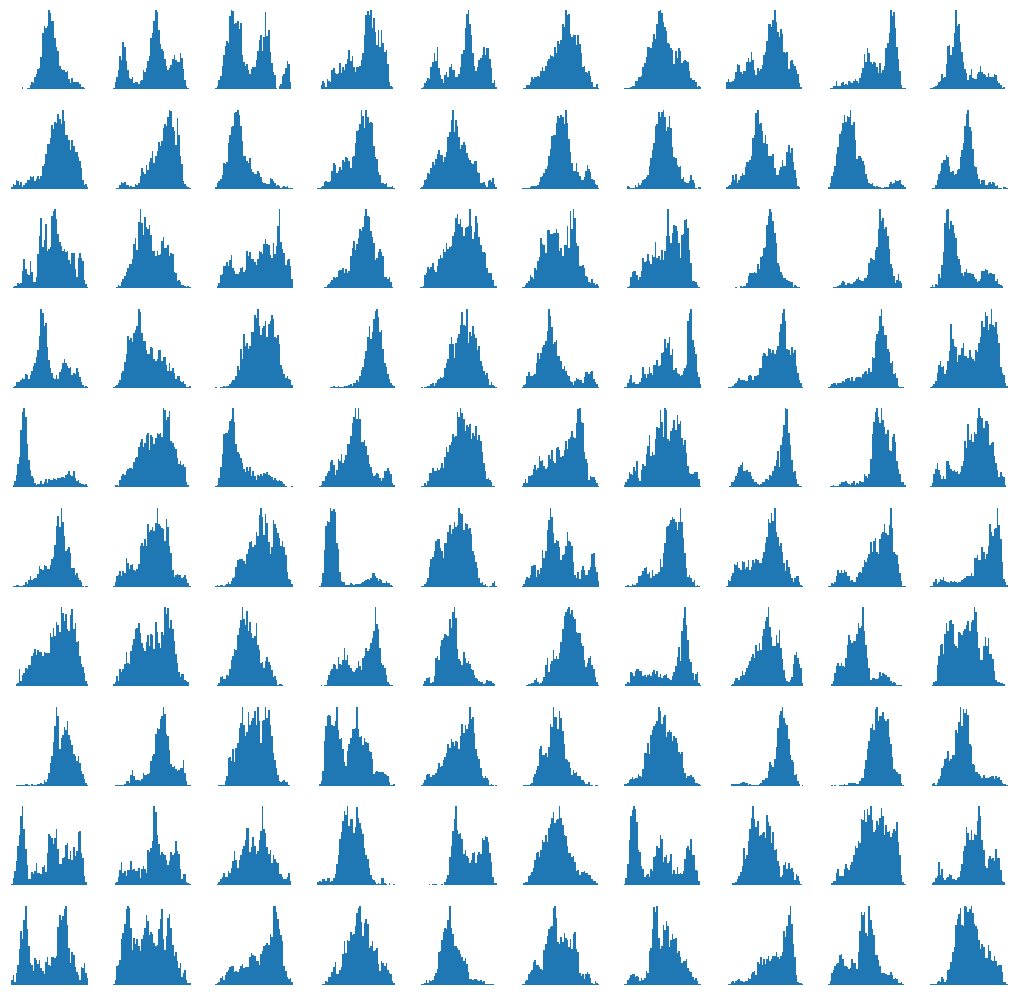

In [213]:
fig,axes=plt.subplots(10,10,figsize=(18,18))
axes=axes.flatten()
for i,ax in enumerate(axes):
    ax.axis(False)
    _=ax.hist(samplesList[0][:,i,8],bins=50)

Text(0.5, 0, 'Re(S0+)')

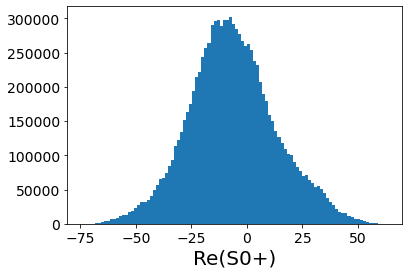

In [215]:
fig,ax=plt.subplots(1,1,figsize=(6,4))
_=ax.hist(samplesList[0].reshape(100000*100,24)[:,0],bins=100)
ax.set_xlabel("Re(S0+)")

## MCMC diagnostic plots - autocorr

### Real and imaginary parts

In [109]:
# These two are equivalent
# NOTE THAT integrated_time ONLY WORKS IF IN ORDER [STEPS, WALKERS, PARAMS]
# resultsMCMC[0].get_autocorr_time()
# emcee.autocorr.integrated_time(resultsMCMC[0].get_chain(discard=0))

binNum=0

minstep=100
maxstep=resultsMCMC["chain"][0].shape[0] #15000
widthstep=500
steps=range(minstep,maxstep,widthstep)

autocorrs=[]
for step in steps:
    #autocorrs.append(emcee.autocorr.integrated_time(resultsMCMC[binNum].get_chain(discard=0)[:step,:,:],quiet=True))
    autocorrs.append(emcee.autocorr.integrated_time(resultsMCMC["chain"][binNum][:step,:,:],quiet=True))
    
autocorrs=npy.stack(autocorrs,axis=1)

The chain is shorter than 50 times the integrated autocorrelation time for 22 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [10.2754084          nan  9.30261338         nan  9.87702217  9.85884448
 10.28854334 10.59608072 11.27429612 10.29495536 10.5272265  10.26238538
 11.00809233 10.20290665 10.81374216 10.22764082 10.26888497  9.84974663
 10.33900095 10.59416392 10.36367215 10.56318308 10.19940684 10.10735561]
The chain is shorter than 50 times the integrated autocorrelation time for 22 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 12;
tau: [58.62864053         nan 60.95053474         nan 60.96910984 60.84655262
 60.78300928 64.12520364 64.48838795 57.24618262 61.46414429 62.38145657
 67.15220815 60.68159801 62.96242093 60.95560628 60.09757428 59.62395552
 60.42315494 62.93400955 65.81428524 62.28140609 57.69171076 62.4054547 ]
The chain is shorter than 50 times the integrated autocorrelation time for 22 parameter(s

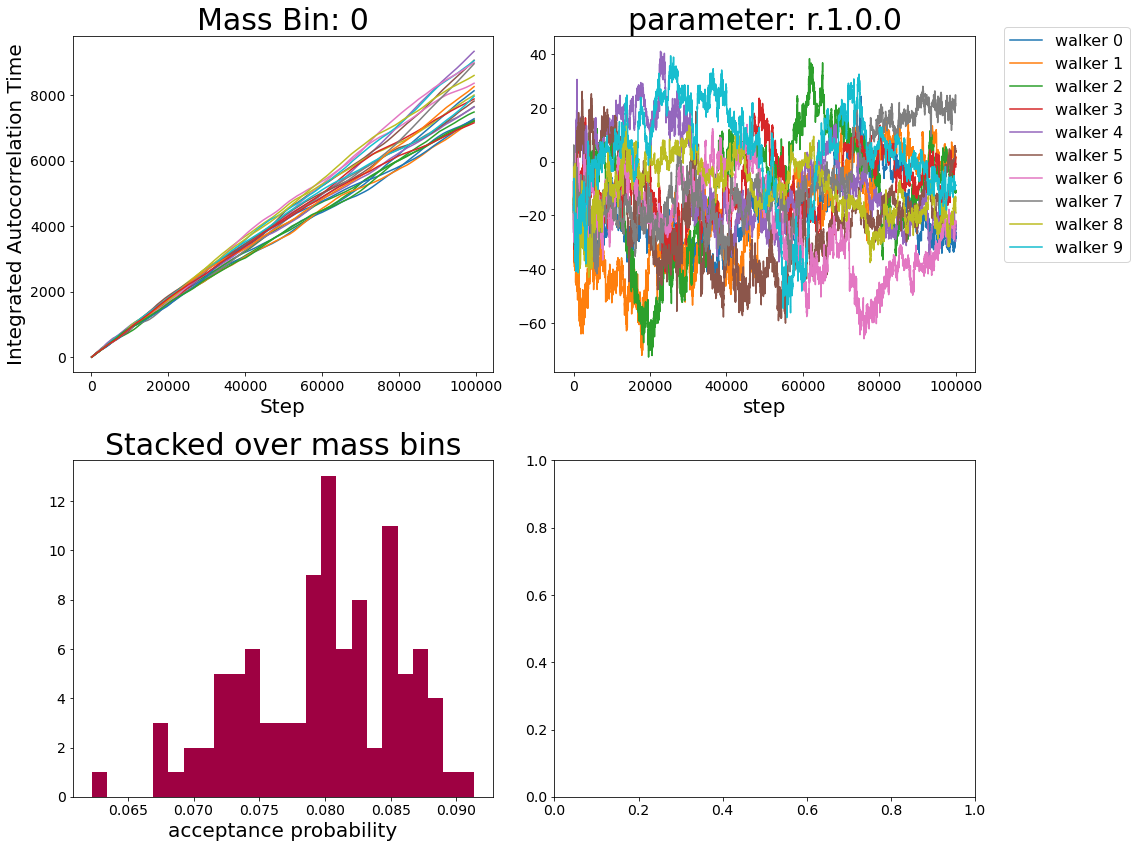

In [110]:
fig,ax=plt.subplots(2,2,figsize=(16,12))

for iparam in range(autocorrs.shape[0]):
    _=ax[0,0].plot(steps,autocorrs[iparam])
ax[0,0].set_xlabel("Step")
ax[0,0].set_ylabel("Integrated Autocorrelation Time")
ax[0,0].set_title(f"Mass Bin: {binNum}",size=30)

iparam=0
for iwalker in range(10):
    _=ax[0,1].plot(resultsMCMC["chain"][binNum][:,iwalker,iparam],label="walker "+str(iwalker))
ax[0,1].set_xlabel("step")
ax[0,1].set_title(f"parameter: {initial[iparam]}",size=30)
ax[0,1].legend(prop={"size":16},bbox_to_anchor=(1.05,1.05))

cmap = matplotlib.cm.get_cmap('Spectral')
ax[1,0].hist(results_pkl["acceptance_fraction"],bins=25,stacked=True,color=list(map(cmap,npy.linspace(0,1,len(results_pkl["acceptance_fraction"])))))
ax[1,0].set_xlabel("acceptance probability")
ax[1,0].set_title("Stacked over mass bins",size=30)

plt.tight_layout()

### Amplitude and phases

In [52]:
# These two are equivalent
# resultsMCMC[0].get_autocorr_time()
# emcee.autocorr.integrated_time(resultsMCMC[0].get_chain(discard=0))

binNum=0
minstep=100
maxstep=resultsMCMC["chain"][0].shape[0] #15000
widthstep=100
steps=range(minstep,maxstep,widthstep)

apsamples=convertToAP(resultsMCMC["chain"][binNum])

autocorrs_ap=[]
for step in steps:
    #autocorrs[iwalker].append(emcee.autocorr.integrated_time(flatSamplesList[:step,0],quiet=True)[0])
    autocorrs_ap.append(emcee.autocorr.integrated_time(apsamples[:step,:,:],quiet=True))
    
autocorrs_ap=npy.stack(autocorrs_ap,axis=1)

The chain is shorter than 50 times the integrated autocorrelation time for 22 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [10.38926656         nan  9.98633631         nan  9.5993963   9.50706364
 10.72591687 10.25877551  9.58368862  9.33932671  9.49481969  9.99884985
 10.17022718  9.96226662  9.55443698  9.33266566 10.23673534  9.95449337
 10.19005748 10.1757768   9.91596749  9.61319652  9.98476956 10.20367492]
The chain is shorter than 50 times the integrated autocorrelation time for 22 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 4;
tau: [20.05033427         nan 20.09004104         nan 20.58690796 19.6463363
 20.98945137 21.48188759 20.1502182  19.94817523 18.8377614  18.17829978
 19.31513275 18.65841656 18.85548774 17.81689476 20.25903577 19.64109747
 20.77969814 20.11532772 20.1692988  18.63674324 19.8770838  20.26827581]
The chain is shorter than 50 times the integrated autocorrelation time for 22 parameter(s).

In [ ]:
fig,ax=plt.subplots(2,2,figsize=(16,12))

for iparam in range(autocorrs_ap.shape[0]):
    _=ax[0,0].plot(steps,autocorrs_ap[iparam])
ax[0,0].set_xlabel("Step")
ax[0,0].set_ylabel("Integrated Autocorrelation Time")
ax[0,0].set_title(f"Mass Bin: {binNum}",size=30)

iparam=0
for iwalker in range(5):
    _=ax[0,1].plot(apsamples[:,iwalker,iparam],label="walker "+str(iwalker))
ax[0,1].set_xlabel("step")
ax[0,1].set_title(f"parameter: {apinitial[iparam]}",size=30)
ax[0,1].legend(prop={"size":16})

cmap = matplotlib.cm.get_cmap('Spectral')
ax[1,0].hist(results_pkl["acceptance_fraction"],bins=25,stacked=True,color=list(map(cmap,npy.linspace(0,1,len(results_pkl["acceptance_fraction"])))))
ax[1,0].set_xlabel("acceptance probability")
ax[1,0].set_title("Stacked over mass bins",size=30)

plt.tight_layout()

## Plots to search for ambiguities

In [ ]:
waves=[amp[2:] for amp in initial if amp[0]=="r"]
numwalker=100
burnin=5000
maxsteps=10000

def getIntensitiesInChain(binNum):
    '''
    Spawning threads to compute the correctly weighted wave intensities in each bin
    This actually takes a long time with lots of chains so we will actually choose a sample to return
    '''
    _amp=deepcopy(amplitude)
    _amp.setup(binsmc[binNum])
    flatsample=samplesList[binNum][burnin:maxsteps,...].reshape((maxsteps-burnin)*numwalker,24).copy()
    
    n_rndsamps=2000
    rnd_samps=npy.random.choice(range(len(samplesList[0])),n_rndsamps)
    flatsample=flatsample[rnd_samps,:]
    
    nsamps=len(flatsample)
    intensity=npy.zeros((nsamps,len(waves)))
    for ic in range(nsamps):
        if ic % 500 == 0:
            delta_t = time.time()-globalStart
            print(f"bin{binNum} at sample {ic} / {nsamps} ({delta_t:0.2f}s)")
        resultsMap={wave:flatsample[ic][i] for i,wave in enumerate(initial)}
        for iw in range(len(waves)):
            intensity[ic,iw]=npy.average(binsmc_w[binNum]["weightASBS"]*_amp.calculate_wave(resultsMap,iw))
    #npy.savetxt(f'tmp/intensities_bin{binNum}.txt', intensity, delimiter=',')
    _intensities[binNum]=intensity

_intensities={}
print("Starting pool of workers...")
nthreads=24
globalStart = time.time()
with ThreadPool(nthreads) as p:
#     p.map(getIntensitiesInChain,range(len(binsda)))
    p.map(getIntensitiesInChain,range(len(samplesList)))
globalEnd = time.time()
print("Complete!")

_intensities=list(collections.OrderedDict(sorted(_intensities.items())).values())
_intensities=npy.array(_intensities)

pickle.dump(_intensities,open("acc_corr_yields.pkl","wb"))

In [ ]:
# _intensities=pickle.load("acc_corr_yields.pkl","rb")

In [ ]:
waves = amplitude.make_elm(resultsData["parameters"])
print(waves)

x=_intensities
ipar=0
#fig,axes=plt.subplots(5,9,figsize=(18,10))
fig,axes=plt.subplots(3,10,figsize=(18,8))
axes=axes.flatten()
for ibin,ax in enumerate(axes):
    if ibin not in range(len(x)):
        continue
    ax.hist(x[ibin,:,ipar],bins=50)
    ax.set_title(f"{centers[ibin]:0.2f}")
    ax.axis(False)

In [ ]:
fig,ax=plt.subplots(3,3,figsize=(14,14),sharey=True)
ax=ax.flatten()

refs=["1","-1"]

lms=[]
waves = amplitude.make_elm(resultsData["parameters"])
for i,w in waves.iterrows():
    lm=f"{w['l']}_{w['m']}"
    lms.append(lm)
lms=npy.unique(npy.array(lms))
lms=[lm.split("_") for lm in lms]
lms0=[lm for lm in lms if lm[0]=='0']
lms1=[lm for lm in lms if lm[0]=='1']
lms2=[lm for lm in lms if lm[0]=='2']
lms=lms0+lms2+lms1
lms=npy.array(lms)

centers=[]
for ibin,bin in enumerate(binsmc):
    centers.append(npy.mean(bin["mass"]))
for iax,lm in enumerate(lms):
    ax[iax].step(centers+width,mcounts,label="Data",linestyle='-',c='gray')
    for ref in refs:
        wave=ref+lm[0]+lm[1]
        if ref+lm[0]+lm[1] in mapWaves:
            i = mapWaves[ref+lm[0]+lm[1]]
            marker_cmap = "Reds" if ref=="1" else "Blues"
            for binNum in range(nbins):
                if binNum not in range(len(_intensities)):
                    continue
                intensity=_intensities[binNum].copy()
                count, edge = npy.histogram(intensity[:,i],bins=100)
                count = count/count.max()
                amp_centers = edge[:-1]+(edge[1]-edge[0])/2
                center=centers[binNum]
                if binNum==0:
                    ax[iax].scatter([center]*len(amp_centers),amp_centers, c=count,s=3,alpha=0.3,cmap=marker_cmap,label=wave)
                else:
                    ax[iax].scatter([center]*len(amp_centers),amp_centers, c=count,s=3,alpha=0.3,cmap=marker_cmap)
        
    # Make the legend lookg good
    legend=ax[iax].legend(loc='upper right', title="ε L M",prop={"size":18})
    legend.get_title().set_fontsize('20')
    hl_dict = {handle.get_label(): handle for handle in legend.legendHandles}
    for ref in refs:
        wave=ref+lm[0]+lm[1]
        if ref+lm[0]+lm[1] in mapWaves:
            legend_label_col = "indianred" if ref=="1" else "steelblue"
            hl_dict[wave].set_color(legend_label_col)
            hl_dict[wave].set_sizes([24])
    
    
    ax[iax].set_xlabel(r"$M(\pi^0\eta) GeV$",size=20)
    ylims=ax[iax].set_ylim(bottom=0)


for iax in [0,3,6]:
    ax[iax].set_ylabel("Intensity / 40 MeV",size=20)

plt.tight_layout()

# Compare MAP and MLE

In [ ]:
# ###############################
# # Gather the MAP solutions for all parameters for all bins
# ###############################

# # Some configuration
# samplesList=resultsMCMC["chain"]
# nparams=resultsMCMC["chain"][0].shape[2]
# burnin=14900
# maxsteps=15000
# verbose=False

# def getMAPsolutions(binNum):
#     lowMass=0.7+0.04*binNum
#     uppMass=0.7+0.04*(binNum+1)
#     print("(Thread {0:.0f})Mass range: {1:.2f},{2:.2f}".format(binNum,lowMass,uppMass))
#     flatsample=samplesList[binNum][burnin:maxsteps,...].reshape((maxsteps-burnin)*numwalker,24)
#     flatsample=convertToAP(flatsample)

#     for idx in range(nparams):
#         wave=flatsample[:,idx]

#         X = npy.histogram(wave,bins=100)
#         centers=X[1][:-1]+(X[1][1]-X[1][0])/2
        
#         if wave.std() != 0: # bandwidth must be > 0. wave.std not always guaranteed. i.e. if the wave was fixed to be real
#             kde = KernelDensity(kernel='gaussian', bandwidth=wave.std()/4).fit(wave.reshape(-1,1))
#             density = npy.exp(kde.score_samples(centers.reshape(-1,1)))
#             map_solution=centers[npy.argmax(density)]
#         else:
#             density=X[0]/sum(X[0])
#             map_solution=0
        
#         # Fill dictionaries
#         map_solutions[idx][binNum]=map_solution
#         densities[idx][binNum]=density
#         centerses[idx][binNum]=centers
        

# globalStart = time.time()

# # Pass getMAPsolutions to all the threads
# map_solutions=[{} for idx in range(nparams)]
# densities=[{} for idx in range(nparams)]
# centerses=[{} for idx in range(nparams)]
# nthreads=24
# with ThreadPool(nthreads) as p:
#     p.map(getMAPsolutions,range(len(binsda)))
    
# globalEnd = time.time()

# for i in range(nparams):
#     map_solutions[i]=list(collections.OrderedDict(sorted(map_solutions[i].items())).values())
#     densities[i]=list(collections.OrderedDict(sorted(densities[i].items())).values())
#     centerses[i]=list(collections.OrderedDict(sorted(centerses[i].items())).values())

# print("Elapsed time: {}".format(globalEnd-globalStart))

In [ ]:
# ###########################################################
# # Plotting specific waves intensities and KDE estimates with the following labels attached
# # Useful to visualize the difference between MAP and MLE
# ###########################################################
# idx_of_D2_amp=npy.where(npy.array(apinitial)=="a.1.2.2")[0][0]
# idx_of_D2_phase=npy.where(npy.array(apinitial)=="p.1.2.2")[0][0]
# labels=["D2 intensity", "D2 phase"]

# nbins=45
# nrows=int(npy.ceil(nbins/2))
# fig,ax=plt.subplots(nrows,4,figsize=(16, 4*nrows))
# ax=ax.flatten()

# for binNum in range(nbins):
#     flatsample=samplesList[binNum][burnin:maxsteps,...].reshape((maxsteps-burnin)*numwalker,24).copy()
#     flatsample=convertToAP(flatsample)
    
#     lowMass=0.7+0.04*binNum
#     uppMass=0.7+0.04*(binNum+1)

#     for i,idx in enumerate([idx_of_D2_amp, idx_of_D2_phase]):
#         wave=flatsample[:,idx]
    
#         map_solution=[ele[binNum] for ele in map_solutions][idx]
#         density=densities[idx][binNum]
#         centers=centerses[idx][binNum]
        
#         _=ax[2*binNum+i].hist(wave,bins=50,density=True,alpha=0.6)
#         ax[2*binNum+i].plot(centers,density,linewidth=3,c="royalblue")
#         ax[2*binNum+i].axvline(map_solution,c='indianred',linestyle='--',linewidth=3)
#         ax[2*binNum+i].axvline(apminuitresults.iloc[binNum,idx],c='darkorange',linestyle="--",linewidth=3)
#         for fit_key in resultsData["data"][f"bin{binNum}"].keys():
#             alt_fitresults=resultsData["data"][f"bin{binNum}"][fit_key]
#             alt_fitresults_status=alt_fitresults[0][0]
#             coloralphawidth = ["black",0.8,1] if alt_fitresults_status else ["gray",0.6,0.5]
#             alt_fitresults_values=convertToAP(alt_fitresults[1])[idx]
#             ax[2*binNum+i].axvline(alt_fitresults_values,c=coloralphawidth[0],linestyle="--",alpha=coloralphawidth[1],linewidth=coloralphawidth[2])
#         ax[2*binNum+i].set_xlabel(labels[i])
#         ax[2*binNum+i].set_title(r"{0:0.2f}<Mpi0eta<{0:0.2f}".format(lowMass,uppMass),size=20)

# plt.tight_layout()

In [ ]:
# ####################
# # Convert map_solutions array into a list of dictionary format that is usable by amp.calculate_wave
# # THE INPUTS MUST BE IN REAL AND IMAGINARY SPACE, NOT AMPLITUDES AND PHASES
# ####################
# map_solution_dicts=[]
# for bin_num in range(nbins):
#     map_solution_dict={}
#     for ipar,par in enumerate(resultsData["parameters"]):
#         map_solution_dict[par] = map_solutions[ipar][bin_num]
#     map_solution_dicts.append(map_solution_dict)

# ####################
# # Make calculate the wave content
# ####################
# waves = amplitude.make_elm(resultsData["parameters"])
# wave_nExp = npy.empty([len(waves),len(binsmc)],npy.longdouble)
# for index, the_bin, result in zip(range(len(binsmc)), binsmc, map_solution_dicts):
#     amplitude.setup(the_bin)
#     for i in range(len(waves)):
#         wave_nExp[i][index] = npy.average(binsmc_w[index]["weightASBS"]*amplitude.calculate_wave(result,i))
        
# ######################
# # Make the final plot
# ######################
# # look for the unique LM waves. We will plot each LM wave on a different axis
# #   with different colors for the + and - reflectivity waves
# lms=[]
# for i,w in waves.iterrows():
#     lm=f"{w['l']}_{w['m']}"
#     lms.append(lm)
# lms=npy.unique(npy.array(lms))
# lms=[lm.split("_") for lm in lms]
# lms0=[lm for lm in lms if lm[0]=='0']
# lms1=[lm for lm in lms if lm[0]=='1']
# lms2=[lm for lm in lms if lm[0]=='2']
# lms=lms0+lms2+lms1
# lms=npy.array(lms)

# # Need to track which array element holds which wave
# mapWaves={wave:i for i,wave in enumerate(waves)}

# fig,ax=plt.subplots(3,3,figsize=(14,14),sharey=True)
# ax=ax.flatten()

# centers=[]
# for ibin,bin in enumerate(binsmc):
#     centers.append(npy.mean(bin["mass"]))
# for iax,lm in enumerate(lms):
#     ax[iax].step(centers+width,mcounts,label="Data",linestyle='-',c='gray')
#     for ref in ["1","-1"]:
#         if ref+lm[0]+lm[1] in mapWaves:
#             i = mapWaves[ref+lm[0]+lm[1]]
#             color = "indianred" if ref=="1" else "steelblue"
#             ax[iax].scatter(centers,wave_nExp[i],label=string[i],c=color,s=12)
#     legend=ax[iax].legend(loc='upper right', title="ε L M",prop={"size":12})
#     legend.get_title().set_fontsize('20')
#     ax[iax].set_xlabel(r"$M(\pi^0\eta) GeV$",size=20)
#     ylims=ax[iax].set_ylim(bottom=0)
    
# for iax in [0,3,6]:
#     ax[iax].set_ylabel("Intensity / 40 MeV",size=20)

# plt.tight_layout()

## Make plots with errorbars from percentiles

In [ ]:
len(samplesList)

In [ ]:
# Some configuration
nparams=resultsMCMC["chain"][0].shape[2]
_nbins=29 # temporary solution to having one of the bins in MCMC returning an error

percentiles_16=[]
percentiles_50=[]
percentiles_84=[]
for binNum in range(_nbins):
    print(f"bin{binNum}")
    flatsample=samplesList[binNum][burnin:maxsteps,...].reshape((maxsteps-burnin)*numwalker,24).copy()
    #flatsample=convertToAP(flatsample)
    percentiles_16.append([])
    percentiles_50.append([])
    percentiles_84.append([])
    for idx in range(nparams):
        wave=flatsample[:,idx]
        percentile_16, percentile_50, percentile_84 = npy.percentile(wave, [16, 50, 84])
        percentiles_16[binNum].append(percentile_16)
        percentiles_50[binNum].append(percentile_50)
        percentiles_84[binNum].append(percentile_84)
        
percentiles_16=npy.array(percentiles_16).T
percentiles_50=npy.array(percentiles_50).T
percentiles_84=npy.array(percentiles_84).T


####################
# Convert map_solutions array into a list of dictionary format that is usable by amp.calculate_wave
# THE INPUTS MUST BE IN REAL AND IMAGINARY SPACE, NOT AMPLITUDES AND PHASES
####################
percentile_16_solution_dicts=[]
percentile_50_solution_dicts=[]
percentile_84_solution_dicts=[]
for bin_num in range(_nbins):
    percentile_16_solution_dict={}
    percentile_50_solution_dict={}
    percentile_84_solution_dict={}
    for ipar,par in enumerate(resultsData["parameters"]):
        percentile_16_solution_dict[par] = percentiles_16[ipar][bin_num]
        percentile_50_solution_dict[par] = percentiles_50[ipar][bin_num]
        percentile_84_solution_dict[par] = percentiles_84[ipar][bin_num]
    percentile_16_solution_dicts.append(percentile_16_solution_dict)
    percentile_50_solution_dicts.append(percentile_50_solution_dict)
    percentile_84_solution_dicts.append(percentile_84_solution_dict)


####################
# Make calculate the wave content
####################
waves = amplitude.make_elm(resultsData["parameters"])
wave_nExp_50_err = npy.empty([len(waves),_nbins],list)
wave_nExp_50 = npy.empty([len(waves),_nbins],npy.longdouble)
for index, the_bin, result_16, result_50, result_84 in zip(range(_nbins), binsmc, percentile_16_solution_dicts, percentile_50_solution_dicts, percentile_84_solution_dicts):
    amp.setup(the_bin)
    for i in range(len(waves)):
        wave_nExp_50[i][index] = npy.average(binsmc_w[index]["weightASBS"]*amp.calculate_wave(result_50,i))
        wave_nExp_16 = npy.average(binsmc_w[index]["weightASBS"]*amp.calculate_wave(result_16,i))
        wave_nExp_84 = npy.average(binsmc_w[index]["weightASBS"]*amp.calculate_wave(result_84,i))
        wave_nExp_50_err[i][index] = [abs(wave_nExp_50[i][index]-wave_nExp_16),abs(wave_nExp_50[i][index]-wave_nExp_84)]

        
######################
# Make the final plot
######################
# look for the unique LM waves. We will plot each LM wave on a different axis
#   with different colors for the + and - reflectivity waves
lms=[]
for i,w in waves.iterrows():
    lm=f"{w['l']}_{w['m']}"
    lms.append(lm)
lms=npy.unique(npy.array(lms))
lms=[lm.split("_") for lm in lms]
lms0=[lm for lm in lms if lm[0]=='0']
lms1=[lm for lm in lms if lm[0]=='1']
lms2=[lm for lm in lms if lm[0]=='2']
lms=lms0+lms2+lms1
lms=npy.array(lms)

# Need to track which array element holds which wave
mapWaves={wave:i for i,wave in enumerate(string)}

fig,ax=plt.subplots(3,3,figsize=(14,14),sharey=True)
ax=ax.flatten()

centers=[]
for binNum in range(nbins):
    centers.append(npy.mean(binsmc[binNum]["mass"]))
for iax,lm in enumerate(lms):
    ax[iax].step(centers+width,mcounts,label="Data",linestyle='-',c='gray')
    for ref in ["1","-1"]:
        if ref+lm[0]+lm[1] in mapWaves:
            i = mapWaves[ref+lm[0]+lm[1]]
            color = "indianred" if ref=="1" else "steelblue"
            errs=npy.array([ele for ele in wave_nExp_50_err[i]]).T # need to convert to array first and then transpose it
            ax[iax].errorbar(centers[:_nbins],wave_nExp_50[i],yerr=errs,label=string[i],c=color,markersize=3,ls='none',fmt='o')
    legend=ax[iax].legend(loc='upper right', title="ε L M",prop={"size":12})
    legend.get_title().set_fontsize('20')
    ax[iax].set_xlabel(r"$M(\pi^0\eta) GeV$",size=20)
    ylims=ax[iax].set_ylim(bottom=0)
    
for iax in [0,3,6]:
    ax[iax].set_ylabel("Intensity / 40 MeV",size=20)

plt.tight_layout()

## Draw chains and histograms

In [ ]:
apminuitresults = minuitresults.copy()
for i in range(len(apminuitresults)):
    for iw,wave in enumerate(waves):
        amp=npy.sqrt(minuitresults.loc[i][2*iw]**2+minuitresults.loc[i][2*iw+1]**2)
        phase=npy.arctan2(minuitresults.loc[i][2*iw+1],minuitresults.loc[i][2*iw])
        # amp = sqrt(Re^2+Im^2)
        apminuitresults.loc[i][2*iw] = amp
        # phase = atan2(Im,Re)
        apminuitresults.loc[i][2*iw+1] = phase

apminuitresults.columns = apinitial

In [ ]:
def spawnPlotDrawer(index):
    print(f"Show results for bin #{index}")
    if loadFromFiles:
        samples=samplesList[index]
    else:
        samples = resultsMCMC[index].get_chain(discard=0)
    if use_apinitial:
        samples=convertToAP(samples)
        
    numsteps = len(samples)
    numpars = samples.shape[2]
    fig, axes = plt.subplots(len(_initial), figsize=(10, 70), sharex=True)
    for i in range(len(_initial)):
        ax = axes[i]
        ax.plot(samples[:,:,i])
        ax.set_ylabel(_initial[i])
        ax.set_xlim(0, numsteps)

    axes[-1].set_xlabel("step number");
    if showFigures:
        fig.show()

#     if loadFromFiles:
#         samples=samplesList[index][burnin:,...]
#     else:
#         samples = resultsMCMC[index].get_chain(discard=burnin)
#     if use_apinitial:
#         samples=convertToAP(samples)
#     fig2, axes2 = plt.subplots(len(_initial), figsize=(5, 70), sharex=False)
#     for i in range(len(_initial)):
#         ax = axes2[i]
#         ax.hist(samples[:,:,i], 100,histtype='barstacked')
#         ax.set_ylabel(_initial[i])
#     if showFigures:
#         fig2.show()

    if loadFromFiles:
        flatsample=samplesList[index][burnin:,...].reshape((numsteps-burnin)*numwalker,24)
    else:
        flatsample = resultsMCMC[index].get_chain(discard=burnin,flat=True)
    if use_apinitial:
        flatsample=convertToAP(flatsample)
    varrange = []
    for i in range(len(_initial)):
        varrange.append((flatsample[:,i].min(),flatsample[:,i].max()))
    print(f"Drawing corner plot for bin #{index}")
    fig3 = corner.corner(flatsample,
                        color='royalblue',
                        bins=50,
#                         truths=npy.mean(flatsample,axis=0),
#                         quantiles=minuitresults.loc[index],
                        range=varrange,
                        labels=_initial,
                        fill_contours=True,
                        truth_color='red',
                        label_kwargs={'fontsize':20, 'labelpad':20},
                        hist_kwargs = {'histtype':'stepfilled','alpha':1})
    if showFigures:
        fig3.show()

    # Draw mean and minuit values (from emcee documentation)
    # Extract the axes
    axes = npy.array(fig3.axes).reshape((numpars, numpars))

    # Loop over the diagonal
    for i in range(numpars):
        ax = axes[i, i]
#         ax.axvline(npy.mean(flatsample,axis=0)[i], color="k")
        ax.axvline(_results.loc[index][i], color="r")

    # Loop over the histograms
    for yi in range(numpars):
        for xi in range(yi):
            ax = axes[yi, xi]
#             ax.axvline(npy.mean(flatsample,axis=0)[xi], color="k")
            ax.axvline(_results.loc[index][xi], color="r")
#             ax.axhline(npy.mean(flatsample,axis=0)[yi], color="k")
            ax.axhline(_results.loc[index][yi], color="r")
#             ax.plot(npy.mean(flatsample,axis=0)[xi], npy.mean(flatsample,axis=0)[yi], "sk")
            ax.plot(_results.loc[index][xi], _results.loc[index][yi], "sr")
    
    #######################################################
    #################### SAVE THE FIGURES #################
    #######################################################
    print(f"Saving plots for bin #{index}")
    fig.savefig(f"{plotpath}/{saveFolder}/timeline_mix_bin{index}.pdf")
    #fig2.savefig(f"{plotpath}/{saveFolder}/hist_mix_bin{index}.pdf")
    fig3.savefig(f"{plotpath}/{saveFolder}/corner_bin{index}.pdf")

In [ ]:
def makeFolder(path):
    try:
        os.makedirs(path)
    except OSError:
        if os.path.isdir(path):
            print(f"Directory {path} already exists.")
        else:
            print (f"Creation of the directory {path} failed.")
    else:
        print (f"Successfully created the directory {path}.")

In [ ]:
# Make folders for output
plotpath=f"{outputpath}"
saveFolder="diagnostics_ap"
makeFolder(f"{plotpath}")
makeFolder(f"{plotpath}/{saveFolder}")

# Configuration for plots
burnin=500
nthreads=len(binsda)
loadFromFiles=True
showFigures=False

# Whether to show the amp/phase or re/im plots
_results=apminuitresults
_initial=apinitial
use_apinitial=True

print("Starting pool of workers to draw...")
globalStart = time.time()
with Pool(nthreads) as p:
    p.map(spawnPlotDrawer,range(len(binsda)))
globalEnd = time.time()

print("Elapsed time: {}".format(globalEnd-globalStart))

In [ ]:
##############################
##############################
# Calculate Moments
##############################
##############################

# H000,H010,H011,H020,H021,H022,H100,H110,H111,H120,H121,H122,sigma4,sigmay = amp.calculate_moments_JPAC(result.values)
#H00,H11,H10,H20,H21,H22 = amp.calculate_moments_STD()


##############################
##############################
# Calculate the phase motion
##############################
##############################

# phase = npy.empty(len(binsda))
# for index, the_bin, result in zip(range(len(binsda)), binsda, results):
#     amp.setup(the_bin)
#     phase[index] = amp.Phasediff(result.values,wave[0],wave[1])

# mnip = npy.empty(len(bmass), dtype=[("mass", float), ("intp", float)])
# mnip["mass"] = bmass
# mnip["intp"] = phase
# mnip = pandas.DataFrame(mnip)
# countsp, bin_edges = npy.histogram(mnip["mass"], nbins, weights=mnip["intp"])

# centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# # Add yerr to argment list when we have errors
# yerr = npy.empty(nbins)
# yerr = npy.sqrt(npy.abs(countsp))
# plt.errorbar(centers,countsp, yerr, fmt="o")
# #plt.xlim(.6, 2.5)